In [39]:
import src.dataPipeline as dataPipeline
import importlib


import importlib
importlib.reload(dataPipeline)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

importlib.reload(dataPipeline)


<module 'src.dataPipeline' from 'C:\\Users\\wartm\\Documents\\FHNW\\immo_challenge\\src\\dataPipeline.py'>

In [40]:
def plot_residuals(y_test, y_pred):
    #subplot with residuals vs. predicted values and histogram of residuals
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    #residuals vs. predicted values
    sns.scatterplot(x=y_pred, y=y_test - y_pred, color='blue',ax=axs[0])
    axs[0].axhline(y=0, color='r', linestyle='-')
    axs[0].set_xlabel('Predicted values')
    axs[0].set_ylabel('Residuals')
    axs[0].set_title('Residuals vs. Predicted values')
    #histogram of residuals
    sns.histplot(y_test - y_pred, bins=30, ax=axs[1])
    axs[1].set_title('Histogram of Residuals')
    plt.show()

In [41]:
def calculate_metrics(X_train, y_test, y_pred):
    n = len(y_test)  # Number of observations
    k = X_train.shape[1]  # Number of predictors
    r2 = round(r2_score(y_test, y_pred), 4)
    R2_adjusted = round(1 - (1 - r2) * (n - 1) / (n - k - 1), 4)
    mape = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 4)
    return r2, R2_adjusted, mape

In [42]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize= False,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:41: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:69: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [43]:
df['price_cleaned'].isna().sum()

np.int64(0)

In [44]:
df.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,...,Raised ground floor,Smoking permitted,Swimming pool,View,Washing machine,Waste water connection,Water connection,Wheelchair access,With a summer house,covered
0,On request,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,On request,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Immediately,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.154274,0.188229,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,On request,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,On request,0.0,NaN,NaN,0.333865,0.279276,0.145835,0.109586,0.141473,0.091805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Space extracted', ylabel='price_cleaned'>

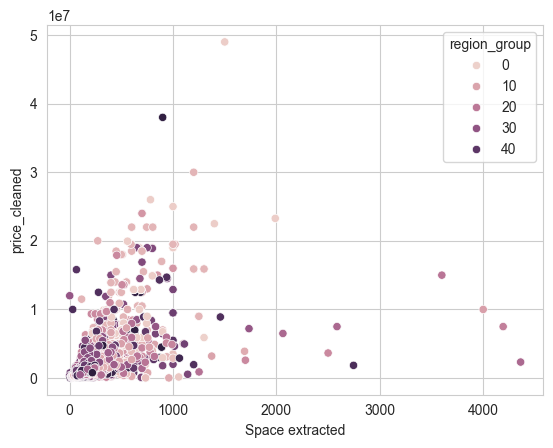

In [45]:
sns.scatterplot(data=df, x="Space extracted", y = "price_cleaned",hue="region_group")

# Lineare Modelle mit Space extracted

In [46]:
df[['Space extracted']].isna().sum()

Space extracted    880
dtype: int64

In [47]:
df[['Space extracted']] = df[['Space extracted']].astype(float)

In [48]:
impute_mean = df.copy()
impute_mean['Space extracted'] = impute_mean['Space extracted'].fillna(impute_mean['Space extracted'].mean())
impute_delete = df.copy()
impute_delete = impute_delete.dropna(subset=['Space extracted'])
impute_median = df.copy()
impute_median['Space extracted'] = impute_median['Space extracted'].fillna(impute_median['Space extracted'].median())
impute_knn = df.copy()
# Versuch Fläche 1 imputieren
impute_knn.loc[impute_knn['Space extracted'] < 5, 'Space extracted'] = np.nan
imputer = KNNImputer(n_neighbors=5)
impute_knn['Space extracted'] = imputer.fit_transform(impute_knn[['Space extracted']])

In [49]:
y = np.log(impute_knn[['price_cleaned']].values)
X = np.log(impute_knn[['Space extracted']].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

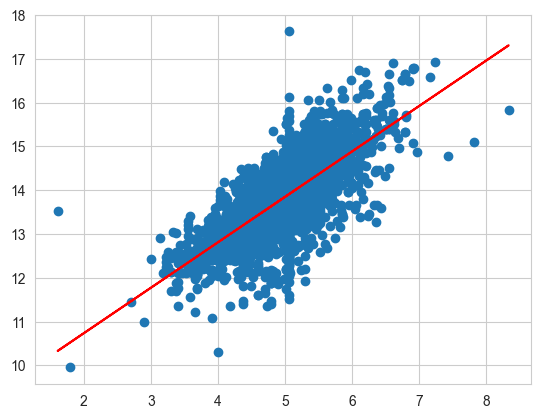

In [50]:
plt.scatter(X_test, y_test)
plt.plot(X_test, model.predict(X_test), color='red')
plt.show()

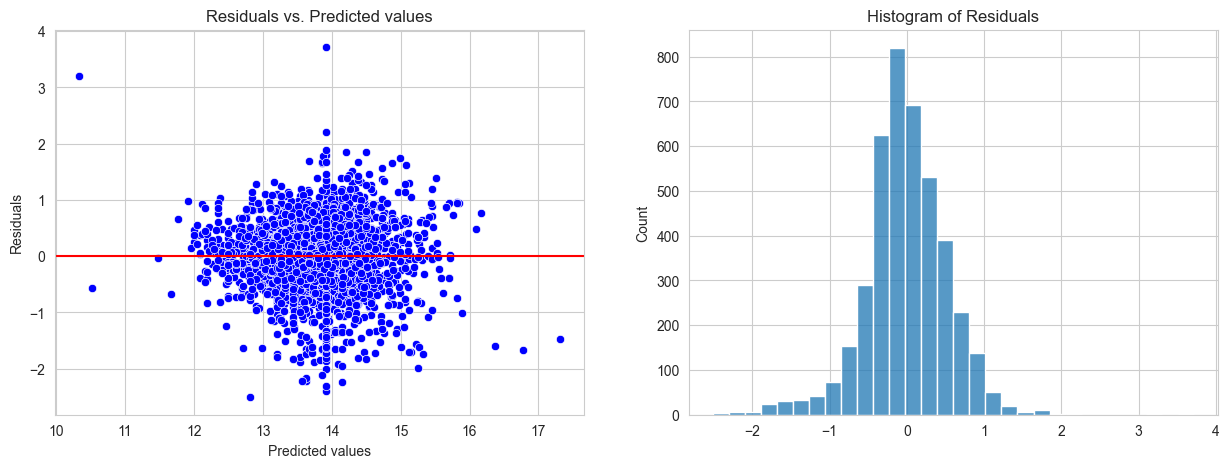

In [51]:
plot_residuals(y_test.flatten(), y_pred.flatten())

In [52]:
#create df with X_test and y_test and y_pred
df_pred = pd.DataFrame(data={'Space extracted': X_test.flatten(), 'price_cleaned': y_test.flatten(), 'price_pred': y_pred.flatten()})

df_pred["Diff"] = df_pred["price_cleaned"] - df_pred["price_pred"]
df_pred

,Space extracted,price_cleaned,price_pred,Diff
0,5.192957,13.769467,14.044382,-0.274916
1,4.219508,13.567049,13.035920,0.531129
2,5.141664,14.089347,13.991244,0.098103
3,4.875197,13.530492,13.715193,-0.184702
4,5.411646,13.637579,14.270937,-0.633358
...,...,...,...,...
4167,5.533389,14.279245,14.397060,-0.117815
4168,5.062335,14.272935,13.909062,0.363873
4169,5.627621,15.761421,14.494681,1.266740
4170,5.062335,14.483340,13.909062,0.574278


In [53]:
#scaling y_pred back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

r2, R2_adjusted, mape = calculate_metrics(X_train,y_test, y_pred)
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.3074,Adjusted R^2:0.3072, MAPE:46.384%


# Lineare Modelle mit Space extracted und No. of rooms

In [54]:
df_two_features = df[['Space extracted', 'No. of rooms:', 'price_cleaned']].copy()
df_two_features.loc[df_two_features['Space extracted'] < 5, 'Space extracted'] = np.nan

#df_two_features['No. of rooms:'] = df_two_features['No. of rooms:'].fillna(1)
#df_two_features['Space extracted'] = df_two_features['Space extracted'].fillna(0)

In [55]:
imputer = KNNImputer(n_neighbors=5)
df_two_features['Space extracted'] = imputer.fit_transform(df_two_features[['Space extracted']])
df_two_features['No. of rooms:'] = imputer.fit_transform(df_two_features[['No. of rooms:']])


In [56]:
df_two_features["Space extracted"] = np.log(df_two_features[['Space extracted']])
df_two_features["No. of rooms:"] = np.log(df_two_features[['No. of rooms:']])

In [57]:
X = df_two_features.drop(columns=["price_cleaned"]).values
y = np.log(df_two_features[['price_cleaned']].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#standardizing with scikit learn
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on training data and transform
X_test = scaler.transform(X_test)       # Transform test data with the same scaler

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


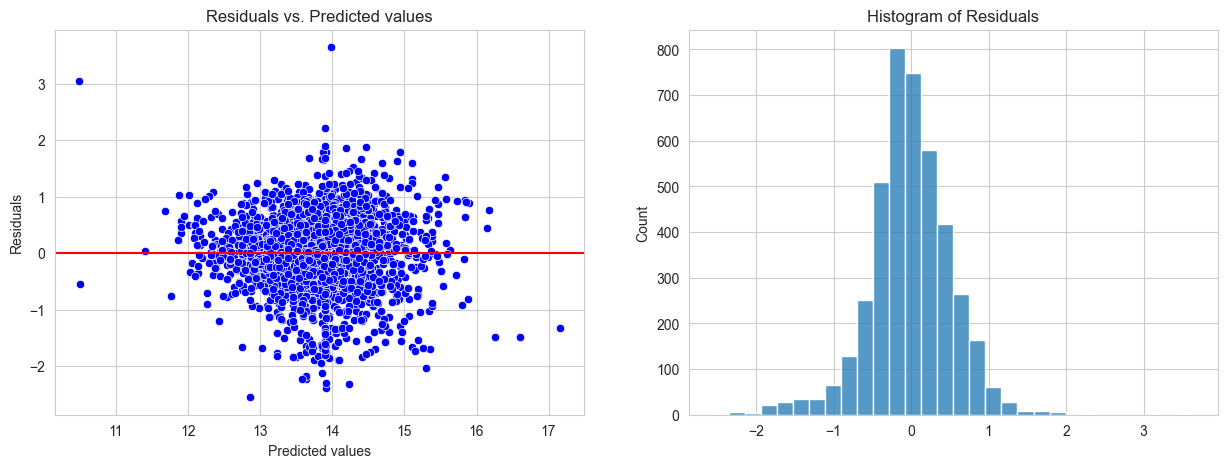

In [58]:
plot_residuals(y_test.flatten(), y_pred.flatten())

In [59]:
#scaling y_pred back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

r2, R2_adjusted, mape = calculate_metrics(X_train,y_test, y_pred)
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.3372,Adjusted R^2:0.3369, MAPE:46.3824%


# Modelle mit einfachen Features


In [60]:
easy_features = ["Floor","price_cleaned","detail_responsive#surface_usable","Number of floors:","Plot_area_unified","Space extracted","No. of rooms:","type_unified"]
df_small = df[easy_features].copy()
df_small.loc[df_small['Space extracted'] < 5, 'Space extracted'] = np.nan
df_small.head()

,Floor,price_cleaned,detail_responsive#surface_usable,Number of floors:,Plot_area_unified,Space extracted,No. of rooms:,type_unified
0,4.0,1150000.0,NaN,NaN,NaN,100.0,5.0,penthouse
1,NaN,1420000.0,NaN,NaN,222.0,156.0,5.0,terrace-house
2,2.0,720000.0,NaN,NaN,NaN,93.0,5.0,penthouse
3,NaN,1430000.0,NaN,NaN,370.0,154.0,5.0,detached-house
4,0.0,995000.0,NaN,NaN,NaN,142.0,5.0,flat


In [61]:
#Filling Floor for House types with zeros
house_types = [
    'detached-house', 'villa', 'semi-detached-house', 'terrace-house',
    'chalet', 'farmhouse', 'rustico', 'castle', 'detached-secondary-suite'
]
df_small.loc[
    (df_small['type_unified'].isin(house_types)) & (df_small['Floor'].isna()),
    'Floor'
] = 0

In [62]:
#Fill na with 0
df_small["detail_responsive#surface_usable"] = df_small["detail_responsive#surface_usable"].fillna(0)
df_small["Number of floors:"] = df_small["Number of floors:"].fillna(1)
df_small["Plot_area_unified"] = df_small["Plot_area_unified"].fillna(0)

In [63]:
#Fill na for Floor, Space extracted No. of rooms: with knn
imputer = KNNImputer(n_neighbors=5)
df_small['Floor'] = imputer.fit_transform(df_small[['Floor']])
df_small['Space extracted'] = imputer.fit_transform(df_small[['Space extracted']])
df_small['No. of rooms:'] = imputer.fit_transform(df_small[['No. of rooms:']])

In [64]:
df_small.isna().sum()

Floor                               0
price_cleaned                       0
detail_responsive#surface_usable    0
Number of floors:                   0
Plot_area_unified                   0
Space extracted                     0
No. of rooms:                       0
type_unified                        0
dtype: int64

In [65]:
df_small['Space extracted'] = np.log(df_small[['Space extracted']])
df_small = pd.get_dummies(df_small, columns=['type_unified'], drop_first=True)

In [66]:
X = df_small.drop(columns=["price_cleaned"]).values
y = np.log(df_small[['price_cleaned']].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#standardizing with scikit learn
scaler = StandardScaler()
X_train[:, :6] = scaler.fit_transform(X_train[:, :6])
X_test[:, :6] = scaler.transform(X_test[:, :6])

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

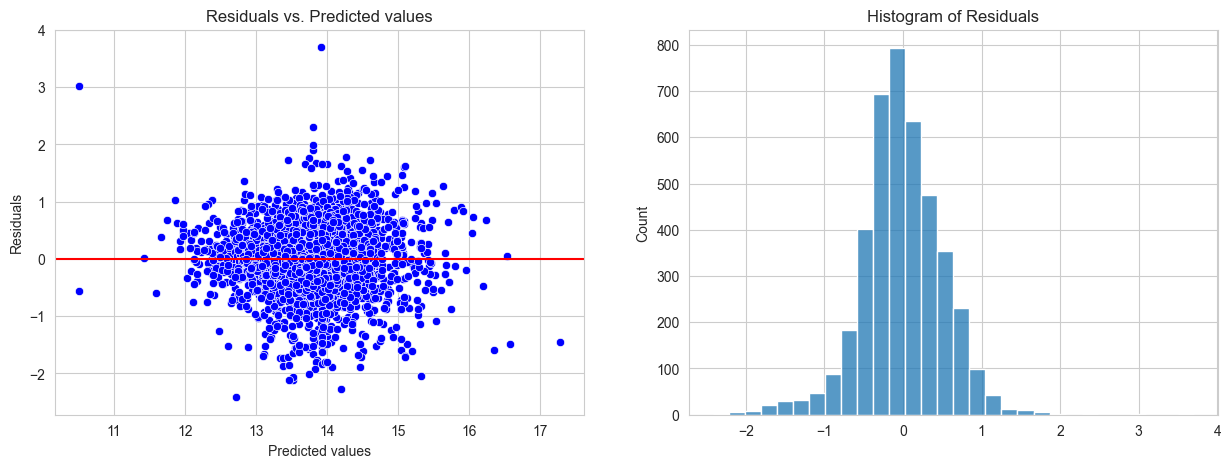

In [67]:
plot_residuals(y_test.flatten(), y_pred.flatten())

In [68]:
#scaling y_pred back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

r2, R2_adjusted, mape = calculate_metrics(X_train,y_test, y_pred)
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.342,Adjusted R^2:0.3379, MAPE:44.7554%


# Modelle mit bestehen Features + Standort

In [69]:
df.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,...,Raised ground floor,Smoking permitted,Swimming pool,View,Washing machine,Waste water connection,Water connection,Wheelchair access,With a summer house,covered
0,On request,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,On request,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Immediately,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.154274,0.188229,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,On request,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.082170,0.001811,0.011871,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,On request,0.0,NaN,NaN,0.333865,0.279276,0.145835,0.109586,0.141473,0.091805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
experiment_standort = ["Floor","price_cleaned","detail_responsive#surface_usable","Number of floors:","Plot_area_unified","Space extracted","No. of rooms:","type_unified", "region_group"]
df_3 = df[experiment_standort].copy()
df_3.loc[df_3['Space extracted'] < 5, 'Space extracted'] = np.nan
df_3.head()

,Floor,price_cleaned,detail_responsive#surface_usable,Number of floors:,Plot_area_unified,Space extracted,No. of rooms:,type_unified,region_group
0,4.0,1150000.0,NaN,NaN,NaN,100.0,5.0,penthouse,18.0
1,NaN,1420000.0,NaN,NaN,222.0,156.0,5.0,terrace-house,18.0
2,2.0,720000.0,NaN,NaN,NaN,93.0,5.0,penthouse,18.0
3,NaN,1430000.0,NaN,NaN,370.0,154.0,5.0,detached-house,18.0
4,0.0,995000.0,NaN,NaN,NaN,142.0,5.0,flat,18.0


In [71]:
#Filling Floor for House types with zeros
house_types = [
    'detached-house', 'villa', 'semi-detached-house', 'terrace-house',
    'chalet', 'farmhouse', 'rustico', 'castle', 'detached-secondary-suite'
]
df_3.loc[
    (df_3['type_unified'].isin(house_types)) & (df_3['Floor'].isna()),
    'Floor'
] = 0
#Fill na with 0
df_3["detail_responsive#surface_usable"] = df_3["detail_responsive#surface_usable"].fillna(0)
df_3["Number of floors:"] = df_3["Number of floors:"].fillna(1)
df_3["Plot_area_unified"] = df_3["Plot_area_unified"].fillna(0)

#Fill na for Floor, Space extracted No. of rooms: with knn
imputer = KNNImputer(n_neighbors=5)
df_3['Floor'] = imputer.fit_transform(df_3[['Floor']])
df_3['Space extracted'] = imputer.fit_transform(df_3[['Space extracted']])
df_3['No. of rooms:'] = imputer.fit_transform(df_3[['No. of rooms:']])

In [72]:
df_3['Space extracted'] = np.log(df_3[['Space extracted']])
df_3 = pd.get_dummies(df_3, columns=['type_unified'], drop_first=True)
df_3 = pd.get_dummies(df_3, columns=['region_group'], drop_first=True)
X = df_3.drop(columns=["price_cleaned"]).values
print(X.shape)
y = np.log(df_3[['price_cleaned']].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#standardizing with scikit learn
scaler = StandardScaler()
X_train[:, :6] = scaler.fit_transform(X_train[:, :6])
X_test[:, :6] = scaler.transform(X_test[:, :6])

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

(20856, 75)


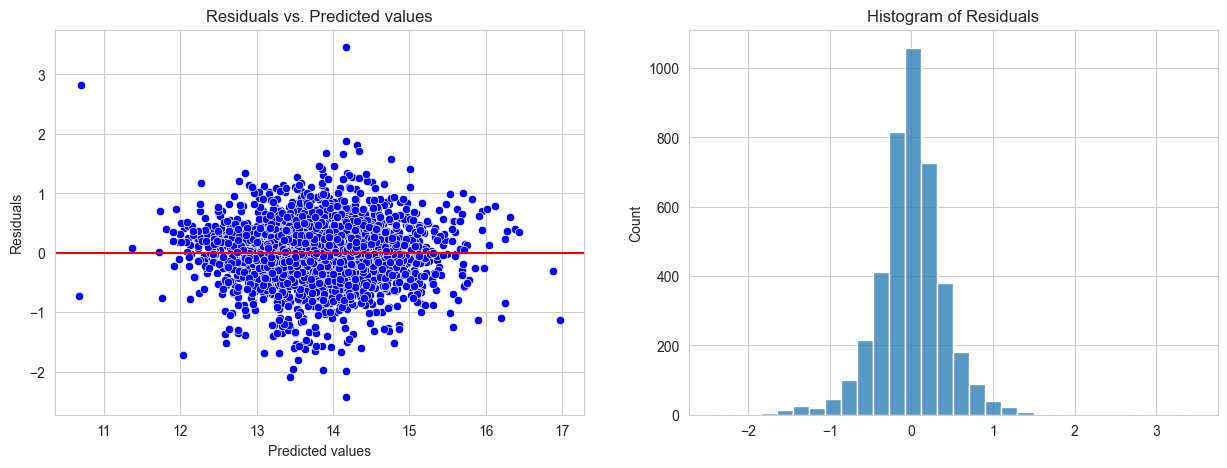

In [73]:
plot_residuals(y_test.flatten(), y_pred.flatten())

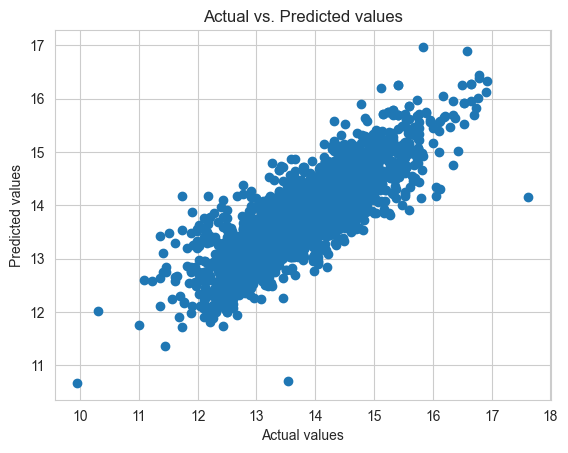

In [74]:
#plotting predicted vs. actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Actual vs. Predicted values')
plt.show()

In [75]:
#scaling y_pred back to original scale
y_pred = np.exp(y_pred)
y_test = np.exp(y_test)

r2, R2_adjusted, mape = calculate_metrics(X_train,y_test, y_pred)
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.5344,Adjusted R^2:0.5259, MAPE:33.4318%


In [76]:
#print training metrics
y_pred_train = model.predict(X_train)
r2, R2_adjusted, mape = calculate_metrics(X_train,y_train, y_pred_train)
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.693,Adjusted R^2:0.6916, MAPE:2.181%
